# Simulation 1

## A simple demonstration of the capabilities of FEP-based attractor networks

Here, we construct a network with 25 subparticles (representing 5x5 images) and train it with 2 different, but correlated images (Pearson's r = 0.77, see Figure [](#fig-network)B), with an precision of 0.1 and a learning rate of 0.01 (see next simulation for parameter-dependence). The training phase consisted of 500 epochs, each showing a randomly selected pattern from the training set through 10 time steps of simultaneous inference and learning. As shown on (fig. [](#fig-network)B), local, micro-scale VFE minimization performed by the simultaneous inference and learning process leads to a macro-scale free energy minimization. Next, we obtained the attractor states corresponding to the input patterns by means of deterministic inference (updating with the expected value, instead of sampling from the $\mathcal{CB}$ distribution, akin to a vanilla Hopfield network). As predicted by theory, the attractor states were not simple replicas of the input patterns, but approximately orthogonalized versions of them, displaying a correlation coefficient of r=-0.19. 
Next, we demonstrated that the network (with stochastic inference) is not only able to retrieve the input patterns from noisy variations of them (fig. [](#fig-network)C), but also generalizes well to reconstruct a third pattern, by combining its quasi-orthogonal attractor states (fig. [](#fig-network)D). Note that this simulation only aimed to demonstrate some of the key features of the proposed architecture, and a comprehensive evaluation of the network's performance, and its dependency on the parameters is presented in the next simulation.



### Imports

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Construct training data

In [23]:
data1 = np.array([[0,0,1,0,0],
                  [0,0,1,0,0],
                  [0,0,4,0,0],
                  [0,0,1,0,0],
                  [0,0,1,0,0],
                 ])

data2 = np.array([[0,0,0,0,0],
                 [0,0,0,0,0],
                 [1,1,4,1,1],
                 [0,0,0,0,0],
                 [0,0,0,0,0],
                 ])

data1 = (data1 - data1.mean()) / data1.std()
data2 = (data2 - data2.mean()) / data2.std()

train_data = np.vstack(([data1.flatten(), data2.flatten()]))

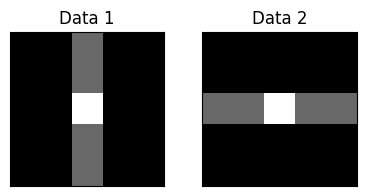

In [24]:

# Convert lists to numpy arrays for plotting
arr1 = np.array(data1)
arr2 = np.array(data2)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(4, 2))

# Plot data1
im1 = axes[0].imshow(arr1, cmap='gray', vmin=0, vmax=2)
axes[0].set_title('Data 1')
axes[0].set_xticks([])
axes[0].set_yticks([])


# Plot data2
im2 = axes[1].imshow(arr2, cmap='gray', vmin=0, vmax=2)
axes[1].set_title('Data 2')
axes[1].set_xticks([])
axes[1].set_yticks([])


# Adjust layout and display the plot
plt.tight_layout()
plt.show()


## Set up and train the network

We use a convenience functions to run and analyze the network, see `simulation.utils.run_network` for implementation details.

In [25]:
from simulation.utils import run_network, get_deterministic_attractors, continous_inference_and_learning

training_output = run_network(
            data=train_data,
            evidence_level=30,
            inverse_temperature=0.1,
            learning_rate=0.01,
            num_epochs=500,
            num_steps=10,
            progress_bar=False # Suppress progress bars within parallel runs
    )

### Get attractors

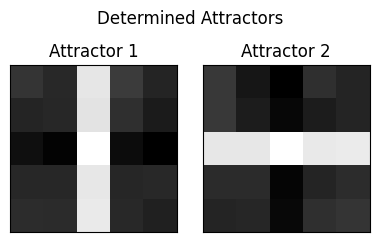

In [26]:
attractors = get_deterministic_attractors(training_output[0], train_data, noise_levels=[0.0], inverse_temperature=1, plot=False)
import matplotlib.pyplot as plt
import numpy as np

num_attractors = len(attractors)
# Assuming attractors are 1D arrays that need reshaping.
# Infer shape from the first attractor, assuming it's a square image.
# Use the shape from the training data used to generate attractors
dim = int(np.sqrt(train_data.shape[1])) # e.g., sqrt(25) = 5

fig, axes = plt.subplots(1, num_attractors, figsize=(num_attractors * 2, 2.5)) # Adjusted figsize slightly

# Handle the case where there's only one attractor (axes might not be an array)
if num_attractors == 1:
    axes = [axes]

fig.suptitle("Determined Attractors") # Add a main title

for i, attractor in enumerate(attractors):
    # Reshape and plot
    # Use gray_r like in get_deterministic_attractors if needed, otherwise gray
    im = axes[i].imshow(attractor.reshape(dim, dim), cmap='gray')
    axes[i].set_title(f'Attractor {i+1}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    # axes[i].set_axis_off() # Alternative to removing ticks

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

# Also print the attractors array if needed for inspection
# attractors

### Compute attractor correlation coefficients

In [27]:
np.corrcoef(train_data)[0,1], np.corrcoef(attractors)[0,1]

(np.float64(0.7706422018348625), np.float64(-0.2043575361668949))

### Visualize VFE

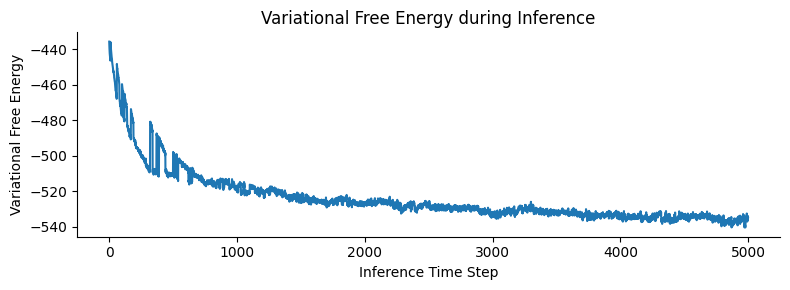

In [28]:
# Plot the Variational Free Energy (VFE) over time
vfe = training_output[5]
plt.figure(figsize=(8, 3))
plt.plot(vfe, label='VFE')
plt.xlabel("Inference Time Step")
plt.ylabel("Variational Free Energy")
plt.title("Variational Free Energy during Inference")
# plt.legend()
plt.tight_layout()
sns.despine()
plt.show()


### Plot the network

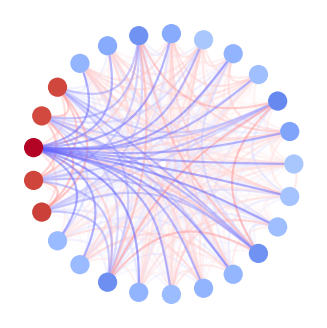

In [29]:
nw = training_output[0]
nw.plot_network(node_size=5, edge_width=0.8)

## Test retrieval of noisy training data

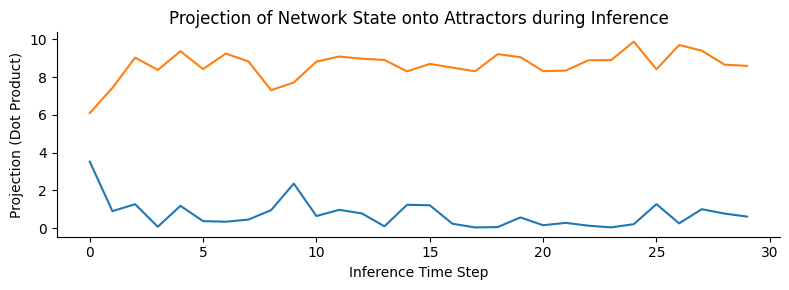

In [33]:
nw = training_output[0]

test_pattern = np.array([[0,0,0,0,0],
                         [0,0,0,0,0],
                         [1,1,1,1,1],
                         [0,0,0,0,0],
                         [0,0,0,0,0],
                         ])
test_pattern = (test_pattern - test_pattern.mean()) / test_pattern.std()
test_pattern = test_pattern.flatten() * 1
test_pattern += np.random.normal(0, 0.5, test_pattern.shape)


acts, _, _, _, _ = continous_inference_and_learning(nw, data=test_pattern, 
                                                        inverse_temperature=1, 
                                                        learning_rate=0.0, 
                                                        num_steps=30)
    
attractors_np = np.array(attractors) # Shape (num_attractors, num_nodes)

acts_np = np.array(acts) # Shape (num_steps, num_nodes)

num_steps_inference = acts_np.shape[0]
num_attractors = attractors_np.shape[0]
num_nodes = attractors_np.shape[1]

# Calculate projections
projections = np.zeros((num_attractors, num_steps_inference))

for t in range(num_steps_inference):
    current_activation = acts_np[t]
    # Project current activation onto each attractor
    projections[:, t] = np.abs(np.dot(attractors_np, current_activation))
    # Optional: Normalize if needed, e.g., by norm of attractors
    # norms_sq = np.sum(attractors_np**2, axis=1)
    # projections[:, t] = np.dot(attractors_np, current_activation) / norms_sq


# Plotting the projections over time
plt.figure(figsize=(8, 3))
for k in range(num_attractors):
    # Assuming attractors correspond to the order in train_data (digits 0-9)
    plt.plot(projections[k, :], label=f'Attractor {k}') 

plt.xlabel("Inference Time Step")
plt.ylabel("Projection (Dot Product)")
plt.title("Projection of Network State onto Attractors during Inference")
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Place legend outside
# plt.grid(True, linestyle='--', alpha=0.6)
sns.despine()
plt.tight_layout()
plt.show()

### Visualize the noisy training pattern

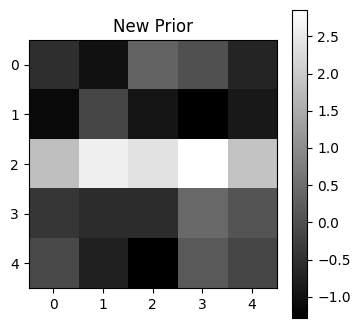

In [34]:
plt.figure(figsize=(4, 4))
plt.imshow(test_pattern.reshape(5, 5), cmap='gray', interpolation='nearest')
plt.title("New Prior")
plt.colorbar()
plt.show()

### Visualize the posterior state

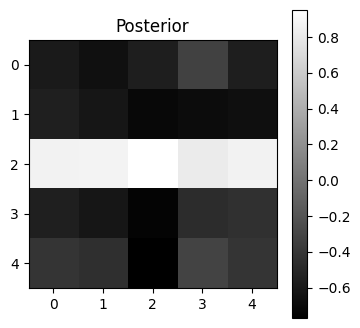

In [35]:
# Visualize the final state
final_state = np.mean(acts, axis=0)
plt.figure(figsize=(4, 4))
plt.imshow(final_state.reshape(5, 5), cmap='gray', interpolation='nearest')
plt.title("Posterior")
plt.colorbar()
plt.show()

## Generalize to new pattern

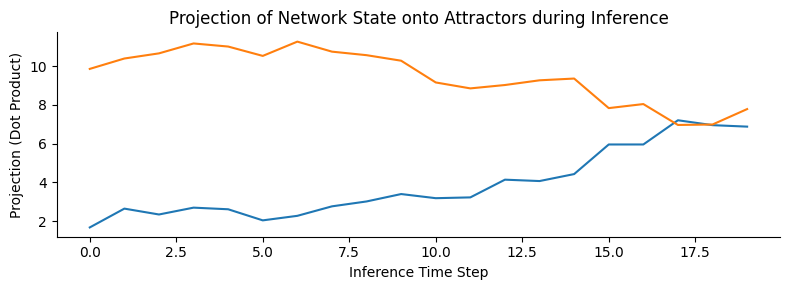

In [30]:


test_pattern = np.array([[0,0,1,0,0],
                         [0,0,1,0,0],
                         [1,1,1,1,1],
                         [0,0,1,0,0],
                         [0,0,1,0,0],
                         ])
test_pattern = (test_pattern - test_pattern.mean()) / test_pattern.std()
test_pattern = test_pattern.flatten() * 1


acts, _, _, _, _ = continous_inference_and_learning(nw, data=test_pattern, 
                                                        inverse_temperature=2, 
                                                        learning_rate=0.0, 
                                                        num_steps=20)
    
attractors_np = np.array(attractors) # Shape (num_attractors, num_nodes)

acts_np = np.array(acts) # Shape (num_steps, num_nodes)

num_steps_inference = acts_np.shape[0]
num_attractors = attractors_np.shape[0]
num_nodes = attractors_np.shape[1]

# Calculate projections
projections = np.zeros((num_attractors, num_steps_inference))

for t in range(num_steps_inference):
    current_activation = acts_np[t]
    # Project current activation onto each attractor
    projections[:, t] = np.abs(np.dot(attractors_np, current_activation))
    # Optional: Normalize if needed, e.g., by norm of attractors
    # norms_sq = np.sum(attractors_np**2, axis=1)
    # projections[:, t] = np.dot(attractors_np, current_activation) / norms_sq


# Plotting the projections over time
plt.figure(figsize=(8, 3))
for k in range(num_attractors):
    # Assuming attractors correspond to the order in train_data (digits 0-9)
    plt.plot(projections[k, :], label=f'Attractor {k}') 

plt.xlabel("Inference Time Step")
plt.ylabel("Projection (Dot Product)")
plt.title("Projection of Network State onto Attractors during Inference")
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Place legend outside
# plt.grid(True, linestyle='--', alpha=0.6)
sns.despine()
plt.tight_layout()
plt.show()

### Visualize the test pattern

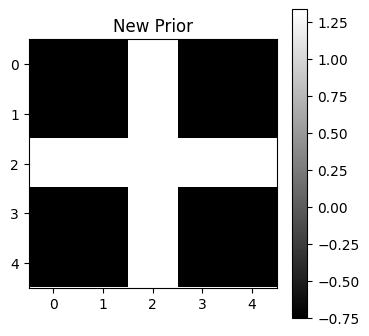

In [31]:
plt.figure(figsize=(4, 4))
plt.imshow(test_pattern.reshape(5, 5), cmap='gray', interpolation='nearest')
plt.title("New Prior")
plt.colorbar()
plt.show()

### Visualize the posterior state

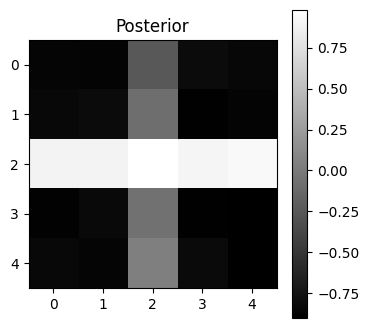

In [32]:
final_state = np.mean(acts, axis=0)
plt.figure(figsize=(4, 4))
plt.imshow(final_state.reshape(5, 5), cmap='gray', interpolation='nearest')
plt.title("Posterior")
plt.colorbar()
plt.show()